# EVBuilder: Mooring data processing from *.raw* files

This notebook goes through the process of:
* Building EV Files
  * Sorting raw files
  * Building EV files from sorted raw file sets
    * Exclusion Lines
    * ST & ET Markers
    * Define Regions
* Exporting $s_{A}$ from EV Files
* Fish Track Detection and Export


In [1]:
from glob import glob
from mooringParams import paramsDAFT1 as processParams # Each mooring has a specific params file with 
import numpy as np
from evFileProcessing import evFuncs # ev COM functions
import cartopy.crs as ccrs
import cartopy.feature as feature
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

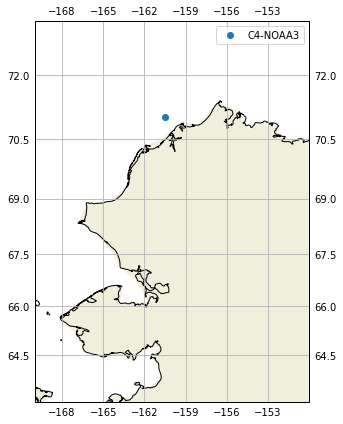

In [2]:
figure = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='10m')
ax.add_feature(feature.LAND)
#ax.plot([-166.85616,-163.1044],[70.013,70.8357],'.k',transform=ccrs.Geodetic())
ax.plot(processParams.wbatParams.mooringLoc[1],processParams.wbatParams.mooringLoc[0],'o',transform=ccrs.Geodetic())
ax.set_extent([-150,-170,63,73])
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
#ax.legend(['All Moorings', processParams.wbatParams.mooringSta +'-'+ processParams.wbatParams.mooringSer])
ax.legend([ processParams.wbatParams.mooringSta +'-'+ processParams.wbatParams.mooringSer])
plt.show()

## .raw File Organizing

We'll read all of the raw files and based on the values defined in the parameters file, organize them into sets of *n* files that will determine the number of EV files to make

## 2018

In [3]:
rawFiles = sorted(glob(processParams.evParams.dataDir + '*0.raw'))
if not rawFiles:
    print('No files found, check "dataDir" in processParams')
fileDateList = []
for file in rawFiles:
    fileDateList.append(file[-22:-14]) # pull out all the date strings
dayList = sorted(set(fileDateList), key=lambda x: fileDateList.index(x)) # keep track of the unique days
# print out some info for the user
print('Found '+ str(len(rawFiles)) +' .raw files \n'+
    'First Wakeup: '+ rawFiles[0][-23:-6] +'\n'+
   'Last Wakeup: '+ rawFiles[-1][-23:-6] +'\n'+
    'Total deployment: ' +str(len(dayList))+' days')
# we're going to make a 'list of lists', each element of 'daysInFile' is a list of the days to include
# (i.e., if numDays == 2, daysInFile = [['date1','date2'],['date3','date4'],...['daten-1','daten']])
days=[]
daysInFile = []
ct = 0
for date in dayList:
    days.append(date)
    ct+=1
    if ct ==processParams.evParams.numDays:
        daysInFile.append(days)
        days = []
        ct=0
daysInFile.append(dayList[-(len(dayList) % processParams.evParams.numDays):])
# daysInFile made above can now be used to compile lists of the actual files 
# to be included in each EV file
fileSets = []
for days in daysInFile:
    fileSets.append([s for s in rawFiles if any(x in s for x in days)])
print('There will be '+str(len(fileSets))+ ' files written')

Found 4448 .raw files 
First Wakeup: D20170809-T040013
Last Wakeup: D20180814-T180013
Total deployment: 371 days
There will be 38 files written


## 2019

In [3]:
rawFiles = sorted(glob(processParams.evParams.dataDir + '*pp.raw'))
if not rawFiles:
    print('No files found, check "dataDir" in processParams')
fileDateList = []
for file in rawFiles:
    fileDateList.append(file[-25:-17]) # pull out all the date strings
dayList = sorted(set(fileDateList), key=lambda x: fileDateList.index(x)) # keep track of the unique days
# print out some info for the user
print('Found '+ str(len(rawFiles)) +' .raw files \n'+
    'First Wakeup: '+ rawFiles[0][-25:-9] +'\n'+
   'Last Wakeup: '+ rawFiles[-1][-25:-9] +'\n'+
    'Total deployment: ' +str(len(dayList))+' days')
# we're going to make a 'list of lists', each element of 'daysInFile' is a list of the days to include
# (i.e., if numDays == 2, daysInFile = [['date1','date2'],['date3','date4'],...['daten-1','daten']])
days=[]
daysInFile = []
ct = 0
for date in dayList:
    days.append(date)
    ct+=1
    if ct ==processParams.evParams.numDays:
        daysInFile.append(days)
        days = []
        ct=0
daysInFile.append(dayList[-(len(dayList) % processParams.evParams.numDays):])
# daysInFile made above can now be used to compile lists of the actual files 
# to be included in each EV file
fileSets = []
for days in daysInFile:
    fileSets.append([s for s in rawFiles if any(x in s for x in days)])
print('There will be '+str(len(fileSets))+ ' files written')

Found 4604 .raw files 
First Wakeup: 20180815-T060016
Last Wakeup: 20190903-T020016
Total deployment: 385 days
There will be 39 files written


# Run Build/Export

In [ ]:
# To build the ev files:
evFiles = evFuncs.evFiles.evBuilder(processParams, fileSets)

In [ ]:
# To export the ev files
evFiles = glob(processParams.evParams.outputDir+'*.EV')
exportFiles = evFuncs.evFiles.evExporter(processParams,evFiles)

In [ ]:
# To export fish tracks
evFiles = glob(processParams.evParams.outputDir+'*.EV')
exportFiles = evFuncs.evFiles.evFishTracks(processParams,evFiles[0:2])

# Reading Exports

In [ ]:
exportFiles = glob(processParams.evParams.outputDir+'\\exports\\Loaded*.csv')
#exportFiles = glob('../data/2018/EVFiles/DAFT1/exports/Loaded*.csv')
df = evFuncs.evExports.readEvExports(exportFiles)
a = df['sA'].resample('2H').sum()

f, [ax1,ax2] = plt.subplots(2,1,figsize=(20,10))
ax1=plt.subplot(111)
a = df['sA'].resample('2H').sum()
a.plot( style='.',label='Wakeups',legend=False,fontsize='18',axes=ax1)
a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
ax1.set_ylim([-500,8000])

sortedDf = df.sort_values(['sA'], ascending=False)
sortedDf.head(40)

## Quick plot of full time series

In [6]:
filesD1Y1 = glob('../data/2018/EVFiles/DAFT1/exports/Loaded*.csv')
filesD1Y2 = glob('../data/2019/EVFiles/DAFT1/exports/Loaded*.csv')
filesD2Y1 = glob('../data/2018/EVFiles/DAFT2/exports/Loaded*.csv')
filesD2Y2 = glob('../data/2019/EVFiles/DAFT2/exports/Loaded*.csv')
filesD3Y2 = glob('../data/2019/EVFiles/DAFT3/exports/Loaded*.csv')
dfD1 = evFuncs.evExports.readEvExports(filesD1Y1+filesD1Y2)
dfD2 = evFuncs.evExports.readEvExports(filesD2Y1+filesD2Y2)
dfD3 = evFuncs.evExports.readEvExports(filesD3Y2)

In [7]:
f, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,11),sharex=True, sharey=True, dpi=600)
ax1=plt.subplot(311)
a = dfD3['sA'].resample('2H').sum()
a.plot( style='.',label='Wakeups',legend=False,fontsize='18',axes=ax1, color='dodgerblue')
a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
ax1.set_ylim([-60,3000])
ax3.set_yticks([0,1000,2000,3000])
ax1.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax1.grid()
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)
ax2=plt.subplot(312)
a = dfD2['sA'].resample('2H').sum()
a.plot( style='.',label='Wakeups',legend=False,fontsize='18',axes=ax2, color = 'gold')
a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax2,linewidth=2,color='k')
ax2.set_ylim([-200,10000])
ax2.set_yticks([0,2500,5000,7500,10000])
ax2.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax2.grid()
ax2.set_xticklabels([])
ax2.xaxis.label.set_visible(False)
ax3=plt.subplot(313)
a = dfD1['sA'].resample('2H').sum()
a.plot( style='.',label='Wakeups',legend=False,fontsize='18',axes=ax3,color='tomato')
a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax3,linewidth=2,color='k')
ax3.set_ylim([-200,10000])
ax3.set_yticks([0,2500,5000,7500,10000])
ax3.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax3.grid()
ax3.set_xlabel('Date', fontsize=18)
ax3.legend(['2-Hour Interval','Daily Mean'],fontsize=18)

plt.subplots_adjust(hspace=.1)
f.text(0.06, 0.5, '70 kHz Backscatter (s$_{A}$, m$^{2}$ nmi$^{-2}$)', va='center', rotation='vertical',fontsize=20);